(sec-acquisitions)=


# Tutorial: Acquisitions

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Acquisitions.ipynb`
```

## Introduction

In this tutorial we give examples on how to add acquisitions to schedules, and how to retrieve acquisition results using the {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator`.
More specifically, this tutorial only describes acquisitions with {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` with Qblox backend with transmon qubits (or Qblox backend with NV center in case of trigger count). See {ref}`sec-tutorial-schedulegettable` for a tutorial on how to perform acquisitions with {class}`~quantify_scheduler.gettables.ScheduleGettable`, and see {ref}`sec-backend-zhinst` for help on how to perform experiments with the Zurich Instruments backend.

This tutorial assumes you are familiar with compiling schedules and running simple pulses on the Qblox hardware. We also assume, that you have basic familiarity with `xarray` (see [xarray introduction](https://quantify-quantify-core.readthedocs-hosted.com/en/latest/technical_notes/dataset_design/Xarray%20introduction.html) and the [official documentation](https://docs.xarray.dev/en/stable/user-guide/data-structures.html)).

The basic structure of the returned acquisition data is that it is an {class}`xarray.Dataset`, which consists of multiple {class}`xarray.DataArray`. Each of these {class}`xarray.DataArray`s correspond to one acquisition channel.

It is important to understand, that this tutorial is Qblox specific with regards to setting up the hardware configuration, and setting up the physical wiring for the hardware, but the schedules and protocols and the return data formats are backend independent.

### Initial setup

First, we set up the connection to the cluster and hardware configuration.

In [1]:
from quantify_core.data import handling as dh
dh.set_datadir(dh.default_datadir())

Data will be saved in:
/home/rsoko/quantify-data


In this tutorial we will use the Qblox dummy device, but for a real hardware, the ip can be provided without the `dummy_cfg` argument.

In [2]:
from qblox_instruments import Cluster, ClusterType
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent

cluster = Cluster("cluster0",
                  "<ip>",
                  dummy_cfg={1: ClusterType.CLUSTER_QRM},
          )
cluster_component = ClusterComponent(cluster)

In [3]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

device = QuantumDevice("device")
transmon0 = BasicTransmonElement("q0")
transmon0.clock_freqs.readout(6e9)
device.add_element(transmon0)
transmon1 = BasicTransmonElement("q1")
transmon1.clock_freqs.readout(6e9)
device.add_element(transmon1)
device.instr_instrument_coordinator("instrument_coordinator")

In [4]:
hardware_config = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster0": {
        "ref": "internal",
        "instrument_type": "Cluster",
        "cluster0_module1": {
             "instrument_type": "QRM",
             "complex_output_0": {
                 "portclock_configs": [
                     {"port": "q0:res", "clock": "q0.ro", "interm_freq": 0},
                     {"port": "q1:res", "clock": "q1.ro", "interm_freq": 0},
                 ]
             }
        }
    },
}
device.hardware_config(hardware_config)

Note here, we used the internal mixer, so `"interm_freq"` was set to `0`.

We set up the {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator`, and we will use the cluster component.

In [5]:
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")

In [6]:
instrument_coordinator.add_component(cluster_component)

## Pulse-level acquisitions

Pulse-level acquisitions define when and how to store and retrieve input signals coming from the device. They are described by their timing information (start time and length), protocol, `acq_channel` and `acq_index_<acq_channel>`.

* Timing information specifies when the acquisition happens on the schedule,
* protocol defines which common hardware and software formatting is done on the input signal.
* `acq_channel` and `acq_index_<acq_channel>` together identify each acquisition for the user in the returned dataset.

In the following subsections we give examples for each supported acquisition protocol.

We assume, that these tutorials are run on a Qblox QRM cluster module. On the QRM module {math}`\text{O}^{[1]}` is connected to {math}`\text{I}^{[1]}` and {math}`\text{O}^{[2]}` is connected to {math}`\text{I}^{[2]}`.

It takes some time before the sent-out signal appears on the input of the QRM, this is the `time_of_flight`.

In [7]:
time_of_flight = 148e-9

### Trace acquisition

One of the simplest protocol is the trace (or scope) acquisition protocol. With this protocol, you can retrieve the input signal in very small timesteps (on nanosecond timescale) for a relatively long time (on microsecond timescale). In this subsection we will send out a DRAG pulse on the output, then measure it with the input of the QRM, and plot the retrieved data. The exact duration of the acquisition and sample times depend on the hardware.

#### Setting up the schedule

Let's define the duration of the DRAG pulse using the parameter `pulse_duration`.

In [8]:
pulse_duration = 1e-6

The schedule is very simple, we transmit the pulse and then we start the trace acquisition which occurs `time_of_flight` seconds after the pulse.

In [9]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.pulse_library import IdlePulse, DRAGPulse
from quantify_scheduler.operations.acquisition_library import Trace

schedule = Schedule("trace_acquisition_tutorial")

schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    DRAGPulse(
        G_amp=0.2, D_amp=0.2, duration=pulse_duration, phase=0,
        port="q0:res", clock="q0.ro",
    ),
)
schedule.add(
    Trace(
        duration=pulse_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=0,
        acq_index=0,
    ),
    ref_pt="start",
    rel_time=time_of_flight
)

{'name': '189cbbcf-549f-4af3-9cf8-58711711c6ef', 'operation_repr': "Trace(duration=1e-06,port='q0:res',clock='q0.ro',acq_channel=0,acq_index=0,bin_mode='average',t0=0)", 'timing_constraints': [{'rel_time': 1.48e-07, 'ref_schedulable': None, 'ref_pt_new': 'start', 'ref_pt': 'start'}], 'label': '189cbbcf-549f-4af3-9cf8-58711711c6ef'}

In [10]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData
import numpy as np
from quantify_scheduler.waveforms import drag

def drag_pulse_waveform():
    duration=1e-6
    t = np.arange(0, duration, 1e-9)
    wave = drag(t=t, G_amp=0.1, D_amp=0.1, duration=duration, nr_sigma=4)

    return [ (wave[i].real, wave[i].imag) for i in range(len(t)) ]

dummy_slot_idx = 1
dummy_scope_acquisition_data = DummyScopeAcquisitionData(
    data=drag_pulse_waveform(), out_of_range=(False, False), avg_cnt=(0, 0)
)

cluster.set_dummy_scope_acquisition_data(
    slot_idx=dummy_slot_idx,
    sequencer=None,
    data=dummy_scope_acquisition_data
)

Let's compile the schedule.

In [11]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

The compiled schedule can be run, and the acquisitions can be retrieved with the {func}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator.retrieve_acquisition` function.

In [12]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [13]:
acquisition

<xarray.Dataset>
Dimensions:        (acq_index_0: 1, trace_index_0: 1000)
Coordinates:
  * acq_index_0    (acq_index_0) int64 0
  * trace_index_0  (trace_index_0) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    0              (acq_index_0, trace_index_0) complex128 0j 0j 0j ... 0j 0j 0j

The acquisition data is stored as an {class}`xarray.Dataset`. While it typically consists of multiple {class}`xarray.DataArray`s, this particular dataset contains only one {class}`xarray.DataArray`. This array corresponds to `acq_channel=0` as that was the only acquisition channel we used. Each `acq_index_<acq_channel>` value represents a 1 ns measurement, given that the Qblox backend employs a trace acquisition with a granularity of 1 ns. The real and imaginary parts of the data correspond to the I and Q components, respectively.

We can also plot these results with the following commands. Notice, that because the data is an {class}`xarray.Dataset`, it's very easy to plot and format the data. We only ran the schedule once, so `repetition=0`.

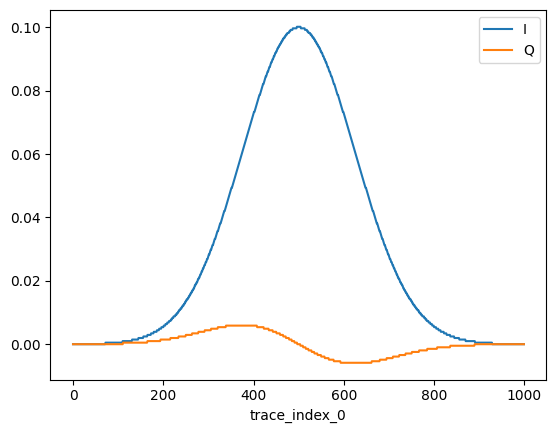

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1)

acquisition[0].real.plot(ax=axs, label="I")
acquisition[0].imag.plot(ax=axs, label="Q")

axs.set_title("")
axs.set_ylabel("")
axs.legend()
plt.show()

### Single-sideband integration acquisition

The single-sideband integration protocol involves integrating the complex input signal over a given time period. The integration weight is a square window, and this window's length is the same as the acquisition length. The signal is demodulated using the specified clock before the integration happens.

In this tutorial, we will send 4 square pulses out, and measure it in 4 separate bins, indexed by all combinations of `acq_channel=0,1` and `acq_index_<acq_channel>=0,1`. We will also send out purely real and imaginary pulses (or purely I and purely Q pulses), and observe that they appear as real and imaginary acquisitions. In case of single-sideband integration the integration happens after demodulation.


Typically, different acquisition channels are usually set up to refer to different qubits. However, in our simple example, we only use a single qubit port-clock combination for both acquisition channels.

#### Setting up the schedule

Let's define how much time the pulse takes with `pulse_duration`.

In [15]:
pulse_duration = 120e-9

We define a simple helper function that sends out the square pulse with `pulse_level` complex amplitude, and then measures it after `time_of_flight` seconds.

In [16]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.pulse_library import IdlePulse, SquarePulse
from quantify_scheduler.operations.acquisition_library import SSBIntegrationComplex
from quantify_scheduler.enums import BinMode

schedule = Schedule("ssb_acquisition_tutorial")

schedule.add(IdlePulse(duration=1e-6))

def pulse_and_acquisition(pulse_level, acq_channel, acq_index, schedule, bin_mode=BinMode.AVERAGE):
    schedule.add(
        SquarePulse(
            duration=pulse_duration,
            amp=pulse_level,
            port="q0:res",
            clock="q0.ro",
        ),
        rel_time=1e-6,
    )
    schedule.add(
        SSBIntegrationComplex(
            t0=time_of_flight,
            duration=pulse_duration,
            port="q0:res",
            clock="q0.ro",
            acq_channel=acq_channel,
            acq_index=acq_index,
            bin_mode=bin_mode,
        ),
        ref_pt="start",
        rel_time=time_of_flight
    )

pulse_and_acquisition(pulse_level=0.125,  acq_channel=0, acq_index=0, schedule=schedule)
pulse_and_acquisition(pulse_level=0.125j, acq_channel=0, acq_index=1, schedule=schedule)
pulse_and_acquisition(pulse_level=0.25,   acq_channel=1, acq_index=0, schedule=schedule)
pulse_and_acquisition(pulse_level=0.25j,  acq_channel=1, acq_index=1, schedule=schedule)

Notice, that the amplitude is double in case of `acq_channel=1` compared to `acq_channel=0`. Also, the amplitude is complex: in case `acq_index_<acq_channel>=0` the amplitude is real, and in case `acq_index_<acq_channel>=1` the amplitude is imaginary.

In [17]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(0, 16), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)
dummy_data_1 = [
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(0, 32), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="1", data=dummy_data_1)

Let's compile the schedule.

In [18]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [19]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [20]:
acquisition

<xarray.Dataset>
Dimensions:      (acq_index_0: 2, acq_index_1: 2)
Coordinates:
  * acq_index_0  (acq_index_0) int64 0 1
  * acq_index_1  (acq_index_1) int64 0 1
Data variables:
    0            (acq_index_0) complex128 (0.13333333333333333+0j) 0.13333333...
    1            (acq_index_1) complex128 (0.26666666666666666+0j) 0.26666666...

There are now two {class}`xarray.DataArray`s in this {class}`xarray.Dataset`. These correspond to `acq_channel=0` and `acq_channel=1`. Both of these `DataArrays` have the following two dimensions: `acq_index_<acq_channel>` and `repetition`. Because the schedule was run only once, `repetition=0` for all values.

As expected, the single side band integration produced a single complex number in each bin. One purely real value in `acq_index_<acq_channel>=0` and one purely imaginary value in `acq_index_<acq_channel>=1`. Notice how these values are twice as much for `acq_index_<acq_channel>=1` as compared to those for `acq_index_<acq_channel>=0`.

#### Bin modes and repetitions

`quantify-scheduler` offers two kinds of bin modes, that deal with repeated schedules:

- Average bin mode: Enables repeated measurements and averaging for reduced errors.
- Append bin mode: Allows repeating measurements and retrieving data for each repetition individually.

```{note}
`QuantumDevice.cfg_sched_repetitions` has no effect on experiments running with {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` itself by the user. This parameter has only effect if you're using {class}`~quantify_scheduler.gettables.ScheduleGettable`.
```

To determine the number of times you want the `quantify-scheduler` to execute the schedule, you can set the `repetitions` argument or attribute for the `Schedule` object. By specifying a value for `repetitions`, you can control the number of times the schedule will run. For example, if you set `repetitions` to `8`, the following code snippet demonstrates a schedule that would execute eight times:


```{code-block} python
schedule = Schedule("Repeated schedule", repetitions=8)
```

```{note}
Important: mixing bin modes is not allowed and all bin modes must be the same for each acquisition in one schedule!
```

##### Average bin mode

To specify which bin mode you would like to use, set the `bin_mode` argument for each acquisition operation. By default, they are set to `BinMode.AVERAGE`.

```{code-block} python
from quantify_scheduler.enums import BinMode

schedule.add(
    SSBIntegrationComplex(
        duration=pulse_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=acq_channel,
        acq_index=acq_index,
        bin_mode=BinMode.AVERAGE,
    )
)
```

```{note}
Trace acquisitions only work with average bin mode. Integration type acquisitions can be used with append bin mode too.
```

##### Append bin mode

Let's create a schedule which is run 3 times in a row in append mode.

In [21]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.pulse_library import IdlePulse, SquarePulse
from quantify_scheduler.operations.acquisition_library import SSBIntegrationComplex
from quantify_scheduler.enums import BinMode

schedule = Schedule("append_tutorial", repetitions=3)

schedule.add(IdlePulse(duration=1e-6))

pulse_and_acquisition(pulse_level=0.125, acq_channel=0, acq_index=0, schedule=schedule, bin_mode=BinMode.APPEND)
pulse_and_acquisition(pulse_level=0.25,  acq_channel=0, acq_index=1, schedule=schedule, bin_mode=BinMode.APPEND)

In [22]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
] * 3
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [23]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

And retrieve the acquisitions

In [24]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [25]:
acquisition

<xarray.Dataset>
Dimensions:      (acq_index_0: 2, repetition: 3)
Coordinates:
  * acq_index_0  (acq_index_0) int64 0 1
Dimensions without coordinates: repetition
Data variables:
    0            (repetition, acq_index_0) complex128 (0.13333333333333333+0j...

Notice, that now we have `3*2` acquisition values, as expected: with 3 repetitions, and for each repetition 2 acquisitions. Let's select the values for the second run.

In [26]:
acquisition[0].sel(repetition=1)

<xarray.DataArray 0 (acq_index_0: 2)>
array([0.13333333+0.j, 0.26666667+0.j])
Coordinates:
  * acq_index_0  (acq_index_0) int64 0 1

As expected, it has only two values, and the value of `acq_index_<acq_channel>=1` is double that of `acq_index_<acq_channel>=0`.

### Trigger count acquisition

The trigger count acquisition protocol is used for measuring how many times the input signal goes over some limit. This protocol is used, for example, in the case of an NV center type of qubit, or other types of qubit, where counting the number of photons (indirectly as an electrical signal) is important.

The Trigger Count protocol in `quantify-scheduler` offers two bin modes: average and append mode. These bin modes function differently compared to the Single Sideband Integration protocol.

In the append bin mode, the resulting data will be a list of 1s, with the length of the list corresponding to the number of triggers that occurred during the acquisition. For example, if there were three triggers, the result would be a list with three 1s: `[1, 1, 1]`.

In the average bin mode, the result is a distribution, mapping from the count numbers to the number of occurrences for each count numbers. It provides insights into the overall occurrence of triggers when running the acquisition multiple times. Let's consider an example where we execute a schedule three times:

- during the 1st run, three triggers are acquired
- during the 2nd run, one trigger is acquired,
- during the 3rd run, one trigger is acquired.

The overall distribution of triggers would be: 1 trigger occurred twice, and 3 triggers occurred once. Hence, the resulting dictionary would be: `{1: 2, 3: 1}`.

The dictionary notation shows the number of triggers as keys and their corresponding frequencies as values.

In this tutorial we will try to see how average bin mode works.
Let's create a schedule which consists of several acquisitions which measure how many times some input pulses occurred with `quantify-scheduler`. In this tutorial we assume input pulses are generated from an external source (we do not generate these sources from the hardware).

The trigger count protocol is currently only implemented for the Qblox backend.


#### Setting up the schedule

Let's define how long time the pulse takes with `pulse_duration`.

In [27]:
pulse_duration = 120e-9

and create the schedule mentioned in the introduction: the hardware will run the trigger count acquisition overall 3 times, therefore `repetitions=3` for the schedule, and in each repetition we run the trigger count acquisition once.
The input signals are the following: the first time the schedule runs there are 3 trigger signals and then 1 trigger signal, and there is again 1 trigger signal at the end.

In [28]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.pulse_library import IdlePulse, SquarePulse
from quantify_scheduler.operations.acquisition_library import TriggerCount
from quantify_scheduler.enums import BinMode

schedule = Schedule("trigger_count_acquisition_tutorial", repetitions=3)

schedule.add(IdlePulse(duration=1e-6))

pulse_duration = 120e-9

schedule.add(
    TriggerCount(
        t0=time_of_flight,
        duration=pulse_duration,
        port="q1:res",
        clock="q1.ro",
        acq_channel=0,
        bin_mode=BinMode.AVERAGE,
    )
)

{'name': '8688a844-88f4-4a8c-a40c-39fa4eebc748', 'operation_repr': "TriggerCount(port='q1:res',clock='q1.ro',duration=1.2e-07,acq_channel=0,acq_index=0,bin_mode='average',t0=1.48e-07)", 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': 'start', 'ref_pt': 'end'}], 'label': '8688a844-88f4-4a8c-a40c-39fa4eebc748'}

The schedule consists of three parts. First 3 trigger pulses, then an acquisition. Then 1 trigger pulse and another acquisition, and finally again one trigger pulse and another acquisition. Notice, that the acquisitions align almost exactly with the pulses, but they are delayed by the delay time. It's also important, that the acquisition channels are the same for both acquisitions. If all of the acquisition channels were different, we would get 3 distributions (for the three acquisition channels).

In [29]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=3),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [30]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [31]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [32]:
acquisition

<xarray.Dataset>
Dimensions:     (repetition: 1, counts: 2)
Coordinates:
  * repetition  (repetition) int64 0
  * counts      (counts) int64 1 3
Data variables:
    0           (repetition, counts) float64 2.0 1.0

There were three trigger acquisitions overall. In the first acquisition 3 triggers were sent-out, and in the second and third case, only one. So, we expect to see that one trigger was measured twice, and 3 triggers were measured only once. The data shows exactly this. At `acq_channel=0` (corresponding to the `0` key in the `Dataset`) the values are `2` and `1`, with `counts` for `1` and `3` respectively.

## Gate-level acquisitions

In the previous section the schedule was defined on the hardware level, in terms of signals and pulses. In this section we will address the acquisitions in terms of qubits. To do that, first, we need to set up a qubit. See {ref}`sec-tutorial-ops-qubits` for an introduction to how to set up a schedule on the gate-level. Integration type acquisitions and trigger count acquisitions make sense on the gate-level, depending on the physical implementation of your qubit.

In this tutorial we will set up a simple single sideband integration acquisition on the gate-level. In the case of a transmon qubit, a {class}`~quantify_scheduler.operations.gate_library.Measure` gate first sends out an acquisition pulse, and then acquires the signal. The {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` stores the parameters of how the measurement gate is translated to device level operations by `quantify-scheduler`.

Let's see what is the effect of modifying the amplitude of the acquisition pulse on the acquisition result. Let's set up the delay time as before, but now on the {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice`, and set up the amplitude of the acquisition pulse, which is a square pulse in this case.

In [33]:
device.remove_element("q0")
transmon0.close()

In [34]:
time_of_flight = 148e-9
pulse_duration = 120e-9

In [35]:
transmon0 = BasicTransmonElement("q0")
transmon0.clock_freqs.readout(6e9)
transmon0.measure.pulse_amp(0.125)
transmon0.measure.pulse_duration(pulse_duration)
transmon0.measure.acq_delay(time_of_flight)
transmon0.measure.integration_time(pulse_duration)
transmon0.measure.acq_channel(2)
device.add_element(transmon0)

Similar to the previous setup, the pulse has an amplitude of 0.125 and matches the duration of the acquisition. In this case, `quantify-scheduler` will use the port `"<name>:res"` for both the acquisition pulse and acquisition itself, specifically `"q0:res"`.  Note, we set the `acq_channel` to `2` for the sake of the example.

The relevant hardware configuration is the following.

```{code-block} python
"portclock_configs": [
        {"port": "q0:res", "clock": "q0.ro", "interm_freq": 0},
    ]
```

### Creating and running the schedule

The qubit is now set up, and we can create the schedule.

In [36]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.pulse_library import IdlePulse
from quantify_scheduler.operations.gate_library import Measure

schedule = Schedule("gate_level_ssb_acquisition_tutorial")

schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    Measure("q0", acq_index=0),
    rel_time=1e-6,
)

{'name': '8338238b-0c67-4115-9822-9e45907e4933', 'operation_repr': 'Measure(\'q0\', acq_index=0, acq_protocol="None", bin_mode=None)', 'timing_constraints': [{'rel_time': 1e-06, 'ref_schedulable': None, 'ref_pt_new': 'start', 'ref_pt': 'end'}], 'label': '8338238b-0c67-4115-9822-9e45907e4933'}

In [37]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="2", data=dummy_data_0)

Let's compile the schedule.

In [38]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [39]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [40]:
acquisition

<xarray.Dataset>
Dimensions:      (acq_index_2: 1)
Coordinates:
  * acq_index_2  (acq_index_2) int64 0
Data variables:
    2            (acq_index_2) complex128 (0.13333333333333333+0j)

Notice, that the result is only one number at `acq_channel=2`.

#### Modifying the readout pulse amplitude

Let's see what the effect on the measurement is if we double the pulse amplitude of the readout pulse

In [41]:
device.remove_element("q0")

In [42]:
transmon0.measure.pulse_amp(0.25)
device.add_element(transmon0)

The amplitude of the read-out pulse is now `0.25`, double what it was.

In [43]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="2", data=dummy_data_0)

Let's compile the schedule.

In [44]:
from quantify_scheduler.backends import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

Let's run the schedule, and retrieve the acquisitions.

In [45]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [46]:
acquisition

<xarray.Dataset>
Dimensions:      (acq_index_2: 1)
Coordinates:
  * acq_index_2  (acq_index_2) int64 0
Data variables:
    2            (acq_index_2) complex128 (0.26666666666666666+0j)

As you can see, because the measurement read-out pulse is now double in amplitude, the measured (acquired) value is now also double compared to the previous case.